##  Predicting Fake are Real News : Data wrangling 


                                By: Muluemebet Ayalew 
                                    June, 2020

In [1]:
# Important libraries
import pandas as pd
import numpy as np
import re # to use regular expression pattern 
import datetime as dt  # to parse to datetime
import string
from scipy import stats

#text processing and visualization
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize, TweetTokenizer
from collections import Counter
from nltk.corpus import stopwords          # to access stop words 
from nltk.stem import WordNetLemmatizer    # for lemmatization or steming
import spacy
from gensim.corpora.dictionary import Dictionary   # to map token , id and create corpus
from sklearn.manifold import TSNE
from wordcloud import WordCloud,STOPWORDS # to visualize frequeent words 
from gensim.models import Phrases  # to use for topic modeling 
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

#for preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # to make word vectors 
from sklearn.model_selection import train_test_split  

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

##  Preprocessing  Outline:
 - tokenization 
 - lowercasing words
 - bag of words
 - lemmatization/stemming
 - removing stop words, punctuations or unwanted tokens
 - experiment with differnt approach 
- check www.snopes.com  to see unproven and false news(webscrap and get data, predicte usig the model
- 
 
 

## 1) Read the data

In [2]:
true= pd.read_csv("True.csv", parse_dates=["date"])     # the true news data
fake= pd.read_csv("Fake.csv")     # the fake news data 

In [3]:
true.head(3) # the first few rows of real dataframe

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31


In [4]:
true.shape # shape of real news before adding label

(21417, 4)

In [5]:
fake.head() # the first few rows of fake dataframe

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.shape  # shape of fake news before adding label

(23481, 4)

### 1.1) Add labels(fake/true) to the  dataframs

In [7]:
# create a new column called is_fake and label as 0 for true news 
true["label"]="true"

In [8]:
# create a new column called is_fake and label as 1 for fake news 
fake["label"]= "fake"

In [9]:
# parse the date column into datetime. 
#Since it has two datetime format, we need two formats to parse.  
def parsing_datetime(string):
    for f in ("%B %d, %Y", '%d-%b-%y', "%b %d, %Y"): # format  19-Feb-18
        try:
            return dt.datetime.strptime(string, f)
        except ValueError:
            pass
        
# parse the date column of fake dataframe into datetime
fake.date= fake.date.apply(lambda x: parsing_datetime(x))

In [10]:
true.head(3)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,true


In [11]:
fake.head(3)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake


### 1.2)  Merge the real and fake dataframe

In [12]:
# Merge the fake and read dataframe
news= pd.concat([true,fake], axis=0)

In [13]:
news.sample(5).head()

,title,text,subject,date,label
9901,WATCH: TUCKER CARLSON DESTROYS Leftist Profess...,This is just one of literally thousands of lib...,politics,2017-09-15,fake
6080,Ryan says Trump to address joint session of Co...,WASHINGTON (Reuters) - U.S. House of Represen...,politicsNews,2017-01-24,true
18657,"Trump to visit Asia in November, North Korea i...",WASHINGTON (Reuters) - Donald Trump will trave...,worldnews,2017-09-29,true
17427,"PRO ABORTION PAC, Emily’s List Doing Its Part ...",Of course Emily s List is going to support Hil...,Government News,2015-04-13,fake
6597,Lawmakers Condemn ‘Dangerous Abuse Of Subpoen...,"Only April 28, nearly 100 lawmakers sent a let...",News,2016-05-01,fake


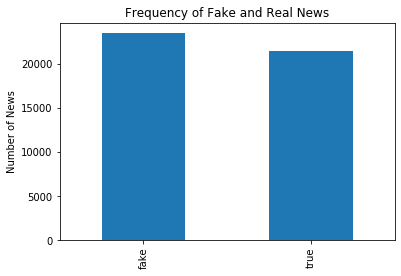

In [14]:
# bar plot the number of fake and real news
_=news.label.value_counts().plot(kind="bar", title="Frequency of Fake and Real News")
_=plt.ylabel("Number of News")


## 2)Explore the data  
Let us explore the two dataframe separately 

### Exploring real news data 

In [20]:
true.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
 4   label    21417 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 836.7+ KB


In [21]:
true.shape #the size of the real dataframe

(21417, 5)

In [22]:
true.iloc[10,1]; # sample text 

In [18]:
true.subject.unique() # unique subjects in the real news 

array(['politicsNews', 'worldnews'], dtype=object)

In [19]:
true[true.text==" "] # one real news without text

,title,text,subject,date,label
8970,Graphic: Supreme Court roundup,,politicsNews,2016-06-16,true


### Explore fake data

In [23]:
fake.info() # see the insormation after creating outcome variable(is_fake) and parsing date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23481 non-null  object        
 1   text     23481 non-null  object        
 2   subject  23481 non-null  object        
 3   date     23471 non-null  datetime64[ns]
 4   label    23481 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 917.4+ KB


In [24]:
fake.shape  # the size of the fake dataframe

(23481, 5)

In [25]:
fake[fake.date.isnull()] # fake news with invalide date 

,title,text,subject,date,label
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,fake
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,fake
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,fake
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,fake
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,fake
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,fake
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,fake
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,fake
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,fake
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,fake


In [26]:
fake.iloc[9358,:] # see one of the fake news with invalid data after parsing 

title      https://100percentfedup.com/served-roy-moore-v...
text       https://100percentfedup.com/served-roy-moore-v...
subject                                             politics
date                                                     NaT
label                                                   fake
Name: 9358, dtype: object

In [27]:
fake[fake.text==" "].shape # 626 fake news without text

(626, 5)

### 2.1) Explore the Subject of fake and real news  

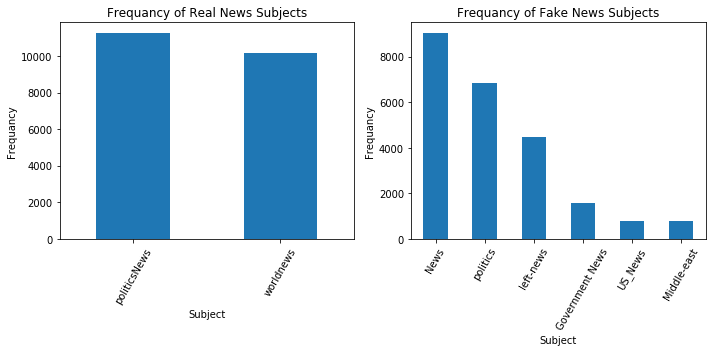

In [28]:
plt.figure(figsize=(10,5))

plt.subplot(121)
_=true.subject.value_counts().plot.bar()
_=plt.ylabel("Frequancy")
_=plt.title("Frequancy of Real News Subjects")
_=plt.xlabel("Subject")
_=plt.xticks(rotation=60)

plt.subplot(122)
_=fake.subject.value_counts().plot.bar()
_=plt.xlabel("Subject")
_=plt.ylabel("Frequancy")
_=plt.title("Frequancy of Fake News Subjects")
_=plt.xticks(rotation=60)

plt.tight_layout()
plt.show()


### 2.2 Explore date 
The year span for the fake news is from 2015 to 2018 whereas the real data has news for 2016 and 2017. The monthes september october, november and december have the most number of news from the real dataset.  

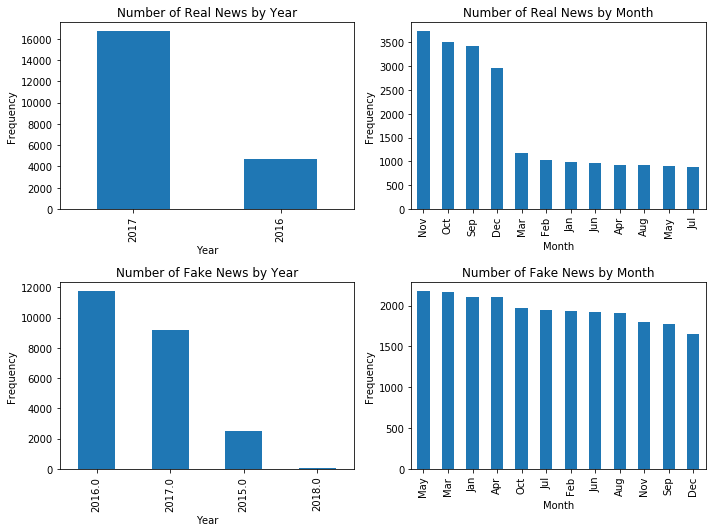

In [29]:
#Exploring Year 

plt.figure(figsize=(10,7.5)) # set figure size

# Number Real news by year 
plt.subplot(221)
true.date.dt.year.value_counts().plot(kind="bar", title="Number of Real News by Year")
plt.xlabel("Year")
plt.ylabel("Frequency")

# Number Real news by month 
plt.subplot(222)
true.date.dt.strftime("%b").value_counts().plot(kind="bar", title="Number of Real News by Month")
plt.xlabel("Month")
plt.ylabel("Frequency")


# Number of fake news by year 
plt.subplot(223)
fake.date.dt.year.value_counts().plot(kind="bar", title="Number of Fake News by Year")
plt.xlabel("Year")
plt.ylabel("Frequency")

#Number of fake news by month
plt.subplot(224)
fake.date.dt.strftime("%b").value_counts().plot(kind="bar", title="Number of Fake News by Month")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.tight_layout()

plt.show()

### 2.3) Explore the news title and text 
The function extract_pattern() is used to count the number of a regular expression pattern appered in a news. For this section it is used to extract for number of emoji, url and  tags.

In [30]:
def extract_pattern(data, pattern):
    """retruns the number of patters appeared in each news"""
    extract= re.findall(pattern, data)
    return len(extract)

### Number of  Emoji in fake and real news

#### Emoji in title 

The title of real news have no emoji symbols at all where as there is one title with emoji for fake news. 

In [31]:
#Emoji symbols
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"


In [32]:
print(emoji)

[🌀-🗿😀-🙏🚀-🛿☀-⛿✀-➿Ⓜ-🉑]+


In [33]:
# maximum number of emoji available in a title of fake news 
fake["num_emoji_ttl"]= fake.title.apply(extract_pattern, pattern=emoji)

fake.title[fake.num_emoji_ttl.idxmax()] # Extract the title with max number of emoji on it 

'SHOCKING MUST WATCH VIDEO: Muslim Leaders Just Openly Declared War On The American Population\ufeff'

In [34]:
# maximum number of emoji available in the title of real news 
true["num_emoji_ttl"]= true.title.apply(extract_pattern, pattern=emoji)

true.num_emoji_ttl.max() # Extract the data title with max number of emoji on it

0

### Emoji in text
There is no emoji symbol in any of the fake text whereas there are three kind of emoji symbols detected from the text of three true news. 

In [35]:
# maximum number of emoji available in the text of fake news 
fake["num_emoji_txt"]= fake.text.apply(extract_pattern, pattern=emoji)

fake.num_emoji_txt.max() # Extract the data title with max number of emoji on it 

0

In [36]:
# maximum number of emoji available in the text of real news 
true["num_emoji_txt"]= true.text.apply(extract_pattern, pattern=emoji)

true.num_emoji_txt.max() # Extract the data title with max number of emoji on it 

3

In [37]:
true[true.num_emoji_txt>0] # There are three news with emoji symbol in real news 

,title,text,subject,date,label,num_emoji_ttl,num_emoji_txt
1179,"Trump on Twitter (Oct 17) - Tom Marino, Greek ...",The following statements were posted to the ve...,politicsNews,2017-10-17,true,0,1
2023,Factbox: Trump on Twitter (Aug 24) - Debt ceil...,The following statements were posted to the ve...,politicsNews,2017-08-24,true,0,3
3673,"Traveling abroad, Trump struggles to escape cr...",RIYADH (Reuters) - President Donald Trump was ...,politicsNews,2017-05-20,true,0,1


In [38]:
# the type of emoji symbols  found in the text of real news
text_emoji=true.text.apply(lambda x: re.findall(emoji,x))
for idx in [1179, 2023, 3673]:
    print(text_emoji.loc[idx])

['➡️']
['☑️', '☑️', '☑️']
['ツ']


### Number of url links in fake and real news

#### Number of url links in title
There are 9 fake news title with url links but none of the title on real news have url link 

In [39]:
# url pattern
url= re.compile("https?://\S+|www\.\S+")

In [40]:
fake["num_url_ttl"]= fake.title.apply(extract_pattern, pattern=url)

len(fake[fake.num_url_ttl>0]) # number of news title with url link 

9

In [41]:
fake[fake.num_url_ttl>0];

In [42]:
true["num_url_ttl"]= true.title.apply(extract_pattern, pattern=url)

len(true[true.num_url_ttl>0])  # number of news title with url link 

0

#### Number of url links in text

In [43]:
fake["num_url_txt"]= fake.text.apply(extract_pattern, pattern=url)

len(fake[fake.num_url_txt>0]) # number of news title with url link 

3356

In [44]:
true["num_url_txt"]= true.text.apply(extract_pattern, pattern=url)

len(true[true.num_url_txt>0]) # number of news title with url link 

41

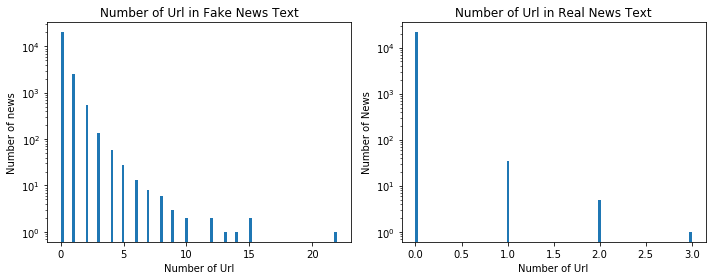

In [45]:
plt.figure(figsize=(10,4))

# plot number of fake news url 
plt.subplot(121)
fake.num_url_txt.plot(kind="hist",bins=100, title="Number of Url in Fake News Text")
plt.yscale("log")
plt.xlabel("Number of Url")
plt.ylabel("Number of news")

# plot number of true news url
plt.subplot(122)
true.num_url_txt.plot(kind="hist",bins=100, title="Number of Url in Real News Text")
plt.yscale("log")
plt.xlabel("Number of Url")
plt.ylabel("Number of News")
plt.tight_layout()
plt.show()

### Tag , mension and & smbols 

#### Tag , mension and & smbols in title 

In [46]:
#pattern for tag(#), mension(@) and & symbols
tag_mensn= "[#@&]+"

In [47]:
fake["num_tag_ttl"]= fake.title.apply(extract_pattern, pattern=tag_mensn)

len(fake[fake.num_tag_ttl>0]) 

862

In [48]:
true["num_tag_ttl"]= true.title.apply(extract_pattern, pattern=tag_mensn)

len(true[true.num_tag_ttl>0]) 

25

#### Tag , mension and & smbols int text

In [49]:
fake["num_tag_txt"]= fake.text.apply(extract_pattern, pattern=tag_mensn)

len(fake[fake.num_tag_txt>0]) 

7682

In [50]:
fake.num_tag_txt.max()

934

In [51]:
fake.text[2902];

In [52]:
true["num_tag_txt"]= true.text.apply(extract_pattern, pattern=tag_mensn)

len(true[true.num_tag_txt>0]) 

1171

Text(0.5, 1.0, 'Frequency of tags in real news title')

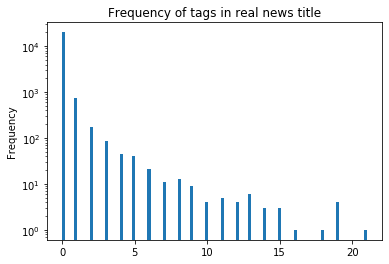

In [53]:
true.num_tag_txt.plot(kind="hist", bins=100)
plt.yscale("log")
plt.title("Frequency of tags in real news title")

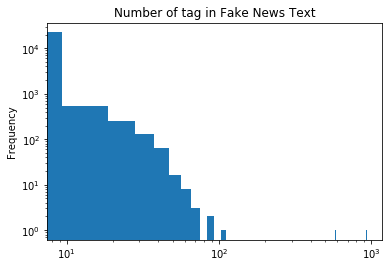

In [54]:
fake.num_tag_txt.plot(kind="hist",bins=100, title="Number of tag in Fake News Text")
plt.yscale("log")
plt.xscale("log")

####  html pattern

In [55]:
html= r'<.*?>'

In [56]:
# html in fake  news title
fake["num_html_ttl"]= fake.title.apply(extract_pattern, pattern=html)
print("Number of fake news title with html tag: ", len(fake[fake.num_html_ttl>0]))

# html in real news  title
true["num_html_ttl"]= true.title.apply(extract_pattern, pattern=html)
print("Number of real news title with html tag: ",len(true[true.num_html_ttl>0]))

Number of fake news title with html tag:  0
Number of real news title with html tag:  0


In [57]:
# html in fake news text
fake["num_html_txt"]= fake.text.apply(extract_pattern, pattern=html)
print("Number of fake news text with html tag: ", len(fake[fake.num_html_txt>0]))


true["num_html_txt"]= true.text.apply(extract_pattern, pattern=html)
print("Number of real news text with html tag: ", len(true[true.num_html_txt>0])) 

Number of fake news text with html tag:  79
Number of real news text with html tag:  8


#### Availablity of number

In [58]:
num=r"\S*\d+\S*" # similar result with re.compile('\d+')

In [59]:
# digits in fake  news title
fake["num_dig_ttl"]= fake.title.apply(extract_pattern, pattern=num)
print("Number of fake news title with digits: ", len(fake[fake.num_dig_ttl>0]))

# digits in real news  title
true["num_dig_ttl"]= true.title.apply(extract_pattern, pattern=num)
print("Number of real news title with digit: ",len(true[true.num_dig_ttl>0]))

Number of fake news title with digits:  3008
Number of real news title with digit:  1799


In [60]:
# digits in fake  news text
fake["num_dig_ttl"]= fake.text.apply(extract_pattern, pattern=num)
print("Number of fake news text with digits: ", len(fake[fake.num_dig_ttl>0]))

# digits in real news  text
true["num_dig_ttl"]= true.text.apply(extract_pattern, pattern=num)
print("Number of real news text with digit: ",len(true[true.num_dig_ttl>0]))

Number of fake news text with digits:  18945
Number of real news text with digit:  17309


## 3)  Data Cleaning preprocessing:
removing html tags, removing, url links, removing, specal characters, remove punctuations, emoji, punctuation, stopwords 

CountVectorizer handles stop words and special characters and punctuation.

    - apply the remove_pattern function and use countvector(it can handle special character punctuation and stop words) to get features and make prediction 
    - also check to limit mx and min df for word count to be consideded as feature
    -compair the result.
    
  title 15392, fake text 83,709, after cleaning with some paterns 78582, 73653 after removing words contining numbers,
#the two data set together, the text has 122,002 features withoucleaning 
    

###  Function to remove patterns(emoji, url, html , special characteres , digits...)

In [61]:
#patterns= [emoji, url, html]
def remove_pattern(text, patterns):
    """The function remove_pattern returns the new string with a set of patterns removed.
       Parameters:
       ------------
       data: the text from which the pattern will be removed
       patterns: is the set of patterns(iterable) we are intereted to remove from the text
       """
           
    for pattern in patterns:
        new= re.sub(pattern, "", text)
        text= new 
    return new

In [62]:
# patterns to be extracted and to be removed from the data 
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"
url= re.compile("https?://\S+|www\.\S+")

html= r'<.*?>' # pattern for html tag

num_with_text= r"\S*\d+\S*" # pattern for digit 

# collect the patterns 
patterns=[emoji, url, html, num_with_text]

### 3.2)  Clean fake and real news dataframe separately

The function remove_pattern() is defined above is used to remove special characters specified by the parameter pattern.

In [63]:
#clean the title of fake and real news using regular expression patterns
fake_ttl_clean= fake.title.apply(remove_pattern, patterns= patterns)
true_ttl_clean= true.title.apply(remove_pattern, patterns= patterns)

In [64]:
# clean the text of fake and real news using regular expression patterns
fake_txt_clean= fake.text.apply(remove_pattern, patterns= patterns)
true_txt_clean= true.text.apply(remove_pattern, patterns= patterns)


### 3.3) Clean merged data

In [68]:
# Clean the title of merged data using regular expression patterns
news_clean_title = news.title.apply(remove_pattern, patterns= patterns)
news_clean_text= news.text.apply(remove_pattern, patterns= patterns)

## 4) Feature vectore: create count vector for the cleaned data

In [69]:
def count_vect(data, min_df):
    """returns the CountVectorizer object and the fitted count vector of the data with 
    the given number of minimum document frequancy.
    parameter:
    -------
        data : collection of text document
        min_df : the minimum document frequency When building the vocabulary """
    
    cv= CountVectorizer(stop_words="english", min_df=min_df)
    trans= cv.fit_transform(data)
    return cv, trans

In [70]:
# count vector for title of the news 
fake_wc_ttl, fake_cv_title= count_vect(fake_ttl_clean,1)
true_wc_ttl, true_cv_title= count_vect(true_ttl_clean, 1)

In [71]:
# feature names for fake and real news title
fake_feature_ttl= fake_wc_ttl.get_feature_names()
true_feature_ttl= true_wc_ttl.get_feature_names()

In [72]:
fake_cv_title.sum(0) #value

matrix([[ 2,  3,  9, ..., 17,  4,  2]], dtype=int64)

In [73]:
df=pd.DataFrame(fake_cv_title.toarray(), columns= fake_feature_ttl)

In [74]:
df.head(2)

,aaron,aarp,abandon,abandoned,abandoning,abandons,abbott,abc,abdication,abdo,...,zombiehillary,zone,zones,zoning,zoo,zoolander,zucker,zuckerberg,état,žižek
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


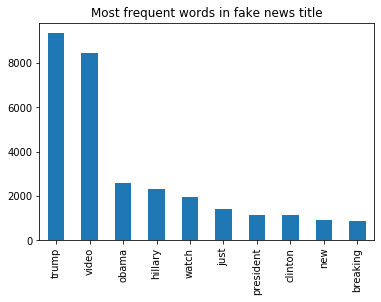

In [75]:
df.sum(0).sort_values(ascending=False)[:10].plot(kind='bar') # frequency of words 
_=plt.title("Most frequent words in fake news title")

## 5) Story about the distribution of number of words appeared in a news and frequancy of words in the datasets

- Note: sum(0) method on count vector object gives the numer of times a word appeared in the whole news article  not just the number of news articles containing a word. A word may appered more then one times in a news and sum up. 

In [107]:
def cum_dist(count_vector, axis): 
    """Displays the emprical cumulative distribution function given the count vector of the text data and 
    the axis on which it is aggregated   """
    
 
    if axis==1: # sum column wise to get the number of words in a news 
        num_words=count_vector.sum(1) # sum number of words in a news 
        x=np.sort(num_words.transpose()) # sort in ascending order
        length=num_words.shape[0] # Number of news 
        xt=x.transpose()
        y= np.arange(1,length+1)/length 
        xlabel="Number of words "
        #title= "Cumulative distribution of news frequency "
               
    elif axis==0 :    #sum row wise to get the number of documents a word appeared            
        
        freq= count_vector.sum(0) #number of times a word apeared in the data 
        length= freq.shape[1]  # number of unique words 
        x= np.sort(freq)
        xt=x.transpose()
        y= np.arange(1,length+1)/length
        xlabel="Frequency of words"
       # title= "Cumulative distribution of word frequency "
    else:
        print("Invalid axis entry!" )
    
    #percentil_80= np.percentile(xt,80) # 80% percentile
    #print((percentil_80))
    _=plt.plot(xt,y)
    _=plt.xlabel(xlabel)
    _=plt.ylabel("Emprical Cummulative Distribution Function")
    #_=plt.title(title)  
    _=plt.xscale("log")
 

In [93]:
#fake_wc_ttl.vocabulary_ ;# dictionary of key= word and value is the indice

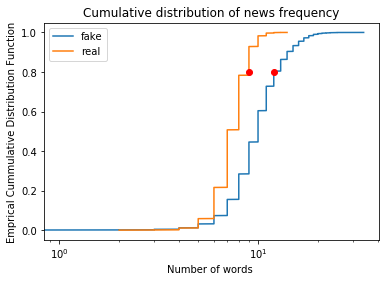

In [108]:
# number of words in a news title 
cum_dist(fake_cv_title, axis=1)
cum_dist(true_cv_title, axis=1)
_=plt.title("Cumulative distribution of news frequency")
plt.legend(["fake", "real"])
#t.hlines(0.8, linestyles="dashed", xmin=1,xmax=12, color="black")
plt.plot((9,12),(0.8,0.8), "ro")
plt.show()

13.0
9.0


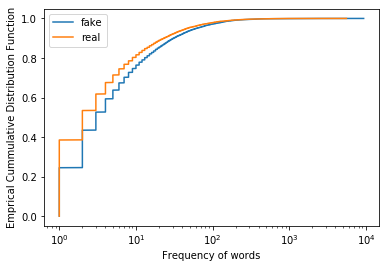

In [104]:
#number of times a word apeared in different news titles  
cum_dist(fake_cv_title, axis=0)
cum_dist(true_cv_title, axis=0)
_=plt.legend(["fake", "real"])

In [105]:
# count vector for text of the news 
fake_wc_txt, fake_cv_text= count_vect(fake_txt_clean,1)
true_wc_txt, true_cv_text= count_vect(true_txt_clean, 1) 

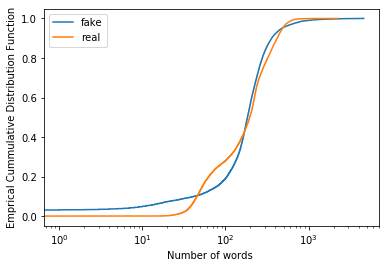

In [109]:
# number of words in a news text 
cum_dist(fake_cv_text,axis=1)
cum_dist(true_cv_text, axis=1)
plt.legend(["fake", "real"])
plt.show()

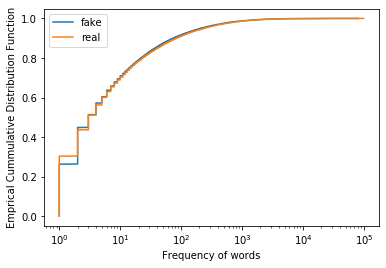

In [110]:
# number of times a word appeared in data 
cum_dist(fake_cv_text,axis=0)
cum_dist(true_cv_text, axis=0)
_=plt.legend(["fake", "real"])

In [111]:
#Shape of the count vector of real news text
true_cv_text.toarray().shape

(21417, 62933)

In [112]:
# shape  of the count vector of fake text
fake_cv_text.toarray().shape

(23481, 78935)

In [113]:
cv_real=CountVectorizer(stop_words="english")
tt= cv_real.fit_transform(true.text)
feature_tr=cv_real.get_feature_names()

In [114]:
cv_fake=CountVectorizer(stop_words="english")
tt= cv_fake.fit_transform(fake.text)
feature_fk=cv_fake.get_feature_names()

## 4) Test statistics: Is the length of the titile determine the type of news? 

The length of fake news and real news title were compared after the data was cleaned. 
H0= the title of fake and real news have the same word length 
H1: Real news have shorter word length 

#### Step1: Formulate the null and alternative hypohesis :

The null hypothesis: The title of fake and real news have the same word length. 
Althernative hypothesis : Real news title have shorter word length.

#### Step 2 : Set the significance level
The significance level, 𝛼 , is set as 0.05(5%) .

#### Step 3: Compute the mean of a concatenated title length
To perform this hypothesis test, we need to shift the two data sets so that they will have the same mean and then use bootstrap sampling to compute the difference of means.

In [115]:
# Compute mean of combined data set: combined_mean
news_clean_title = news.title.apply(remove_pattern, patterns= patterns)

In [116]:
#the mean length of title for both fake and real data are combined
mean_len_ttl= count_vect(news_clean_title,1)[1].sum(1).mean()
print(mean_len_ttl)

8.957058220856164


#### Step 4: Shift the two groups data to get the same mean


In [117]:
# Shift the samples
fake_shifted = fake_cv_title.sum(1) -np.mean(fake_cv_title.sum(1))+ mean_len_ttl
true_shifted = true_cv_title.sum(1) -np.mean(true_cv_title.sum(1))+ mean_len_ttl

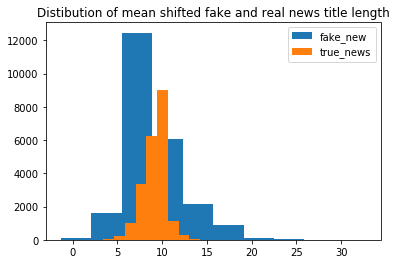

In [118]:
_=plt.hist(fake_shifted,label="fake_news")
_=plt.hist(true_shifted,label="true_news")
_=plt.legend(["fake_new", "true_news"])
_=plt.title("Distibution of mean shifted fake and real news title length")

#### Step 5: Get bootstrap replicates of shifted data sets
Take 10,000 bootstrap replicates,bootstrap replicates are the statistics computed from resampled array(in this case mean), of the mean length of each type of news title.

In [119]:
def bs_repl(data, func, size):
    """ boostrap replicates of the statistics defined by 'func' from bootstraped samples of size equal to 'size'"""
    bs_replicate=np.empty(size)
    for i in range(size):
        bs_sample= np.random.choice(data, size=data.shape[0]) 
        bs_replicate[i]=func(bs_sample) #  the mean of bootstraped samples if the fucntion is mean
    return bs_replicate

In [120]:
bs_replicates_fake = bs_repl(pd.DataFrame(fake_shifted).iloc[:,0], np.mean,10000)
bs_replicates_true = bs_repl(pd.DataFrame(true_shifted).iloc[:,0], np.mean,10000)

#Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_fake - bs_replicates_true

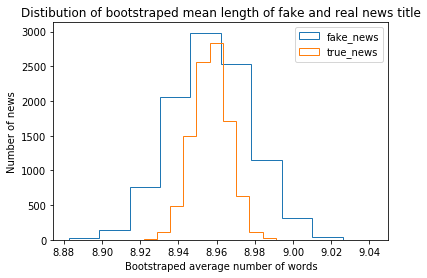

In [121]:
plt.hist(bs_replicates_fake, histtype="step", label="fake_news")
plt.hist(bs_replicates_true, histtype="step", label="true_news")
_=plt.legend()
_=plt.title("Distibution of bootstraped mean length of fake and real news title")
_=plt.xlabel("Bootstraped average number of words")
_=plt.ylabel("Number of news")

#### Step 6: Compute  p-value 

In [122]:
# observed mean diffence
mean_diff_obs= np.mean(fake_cv_title.sum(1))-np.mean(true_cv_title.sum(1))
print("Observed mean difference =",mean_diff_obs )

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff_obs)/len(bs_diff_replicates)

# Print p-value
print('p =', p)

Observed mean difference = 2.753675956525403
p = 0.0


In [123]:

# Percentage of mean diffence below observed diffence 
print("Percentage of mean diffence below observed difference =",stats.percentileofscore(bs_diff_replicates,mean_diff_obs)) 

# compute confidence interval
print("95% confidence interval of bootstraped mean difference: ", np.percentile(bs_diff_replicates,(2.5, 97.5) ))

Percentage of mean diffence below observed difference = 100.0
95% confidence interval of bootstraped mean difference:  [-0.04370574  0.04402789]


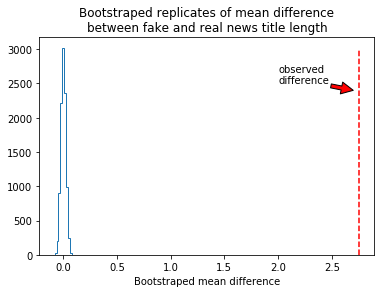

In [124]:
_=plt.hist(bs_diff_replicates, histtype="step")
_=plt.vlines(mean_diff_obs, ymin= 0, ymax=3010, color="red", linestyles="dashed")
_=plt.annotate("observed\ndifference", xytext=(2, 2500), xy=(2.7,2400),arrowprops=dict(facecolor='red'))
_=plt.xlabel("Bootstraped mean difference")
_=plt.title("Bootstraped replicates of mean difference\nbetween fake and real news title length")

**Step 7: Interpretation**

The p- value(0.0) is less than the prespecified significal level(0.05). Therefore, the mean length of fake news title is statistically different from the mean length of real news title. We can conclude that on average fake news title is longer than real news title.  